# 12.3b: Black Hole Population Distribution Analysis

**Goal:** Analyze how token population is distributed across black holes in the 1,000 synthetic trials from 12.2b, and compare to Qwen's actual distribution.

## Key Questions

1. What's the typical hierarchical structure? (largest, 2nd largest, etc.)
2. How much does it vary trial-to-trial?
3. How concentrated is the population? (top-1, top-2, etc.)
4. How does synthetic distribution compare to Qwen's actual [814, 704, 306, ...]?
5. Does the population distribution show Gaussian clustering behavior?

## Parameters

In [1]:
# Data from 12.2b
DATA_PATH = "../data/analysis/sigma_fixed_trials.csv"

# Qwen's actual black hole population distribution (sorted descending)
QWEN_DISTRIBUTION = [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

# Plotting
COLORMAP = 'inferno'

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
import torch

## Load Synthetic Trial Data

In [3]:
print(f"Loading trial data from {DATA_PATH}...\n")

df = pd.read_csv(DATA_PATH)

print(f"✓ Data loaded")
print(f"  Trials: {len(df):,}")
print(f"  σ = {df['sigma'].iloc[0]:.2e}")
print(f"\nBlack hole statistics:")
print(f"  Count (C): {df['n_black_holes'].mean():.1f} ± {df['n_black_holes'].std():.1f}")
print(f"  Population (P): {df['black_hole_population'].mean():.1f} ± {df['black_hole_population'].std():.1f}")
print(f"  Largest BH: {df['largest_bh'].mean():.1f} ± {df['largest_bh'].std():.1f}")

Loading trial data from ../data/analysis/sigma_fixed_trials.csv...

✓ Data loaded
  Trials: 1,000
  σ = 1.50e-09

Black hole statistics:
  Count (C): 12.8 ± 1.1
  Population (P): 2096.6 ± 1.6
  Largest BH: 1107.4 ± 22.8


## Extract Full Population Distributions

For each trial, we need to reconstruct the full population distribution across all black holes.
We'll need to go back to the raw data and recompute this.

In [4]:
print("Reconstructing population distributions from trials...\n")
print("(Note: This requires re-running the analysis on saved embeddings or trial data)")
print("Loading Qwen centroid and regenerating trials...\n")

# Setup
torch.manual_seed(42)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load centroid
centroid_data = load_file("../data/tensors/black_hole_centroid_qwen3_4b.safetensors")
qwen_centroid = centroid_data['centroid'].to(torch.float32).to(device)

# Get parameters from CSV
SIGMA = df['sigma'].iloc[0]
N_TOKENS = int(df['n_tokens'].iloc[0])
HIDDEN_DIM = int(df['hidden_dim'].iloc[0])
N_TRIALS = len(df)

print(f"Regenerating {N_TRIALS} trials with σ={SIGMA:.2e}...")

# Collect population distributions
from tqdm.auto import tqdm

population_distributions = []

for trial_idx in tqdm(range(N_TRIALS), desc="Extracting distributions"):
    # Generate same trial (deterministic with seed)
    noise = torch.randn(N_TOKENS, HIDDEN_DIM, dtype=torch.float32, device=device) * SIGMA
    embeddings = qwen_centroid.unsqueeze(0) + noise
    embeddings = embeddings.to(torch.bfloat16).to(torch.float32)
    
    # Move to CPU for unique
    embeddings_cpu = embeddings.to('cpu')
    
    # Get counts
    unique_vectors, inverse_indices, counts = torch.unique(
        embeddings_cpu,
        dim=0,
        return_inverse=True,
        return_counts=True
    )
    
    # Extract black hole populations (count >= 2)
    black_hole_mask = counts >= 2
    bh_populations = counts[black_hole_mask].tolist()
    
    # Sort descending
    bh_populations.sort(reverse=True)
    
    population_distributions.append(bh_populations)

print(f"\n✓ Extracted {len(population_distributions)} distributions")

Reconstructing population distributions from trials...

(Note: This requires re-running the analysis on saved embeddings or trial data)
Loading Qwen centroid and regenerating trials...

Regenerating 1000 trials with σ=1.50e-09...


Extracting distributions:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Extracted 1000 distributions


## Population Distribution Profile

In [5]:
print(f"\n{'='*60}")
print(f"POPULATION DISTRIBUTION PROFILE")
print(f"{'='*60}")

# Find max BH count across all trials
max_bh_count = max(len(dist) for dist in population_distributions)

print(f"Max black hole count across trials: {max_bh_count}")
print(f"\nPer-rank statistics (sorted by size):")
print(f"{'Rank':<6} {'Mean':<8} {'Median':<8} {'Min':<8} {'Max':<8} {'Qwen':<8} {'Trials':<8}")
print("-" * 60)

# Compute statistics for each rank
rank_stats = []

for rank in range(max_bh_count):
    # Collect populations at this rank across all trials that have it
    pops_at_rank = [dist[rank] for dist in population_distributions if len(dist) > rank]
    
    if pops_at_rank:
        mean_pop = np.mean(pops_at_rank)
        median_pop = np.median(pops_at_rank)
        min_pop = np.min(pops_at_rank)
        max_pop = np.max(pops_at_rank)
        n_trials = len(pops_at_rank)
        qwen_pop = QWEN_DISTRIBUTION[rank] if rank < len(QWEN_DISTRIBUTION) else 0
        
        rank_stats.append({
            'rank': rank + 1,
            'mean': mean_pop,
            'median': median_pop,
            'min': min_pop,
            'max': max_pop,
            'qwen': qwen_pop,
            'n_trials': n_trials,
            'values': pops_at_rank
        })
        
        print(f"{rank+1:<6} {mean_pop:<8.1f} {median_pop:<8.1f} {min_pop:<8.0f} {max_pop:<8.0f} {qwen_pop:<8.0f} {n_trials:<8}")

print(f"{'='*60}")


POPULATION DISTRIBUTION PROFILE
Max black hole count across trials: 17

Per-rank statistics (sorted by size):
Rank   Mean     Median   Min      Max      Qwen     Trials  
------------------------------------------------------------
1      1108.7   1109.0   1031     1185     814      1000    
2      404.4    404.0    358      463      704      1000    
3      356.5    357.0    301      401      306      1000    
4      129.5    130.0    97       171      228      1000    
5      35.6     36.0     18       55       11       1000    
6      17.9     18.0     10       35       10       1000    
7      13.6     13.0     7        22       6        1000    
8      10.4     10.0     5        19       5        1000    
9      7.0      7.0      3        12       4        1000    
10     5.2      5.0      2        10       4        1000    
11     3.7      4.0      2        8        3        985     
12     2.7      3.0      2        6        3        875     
13     2.2      2.0      2        4

## Visualization: Population Distribution Profile

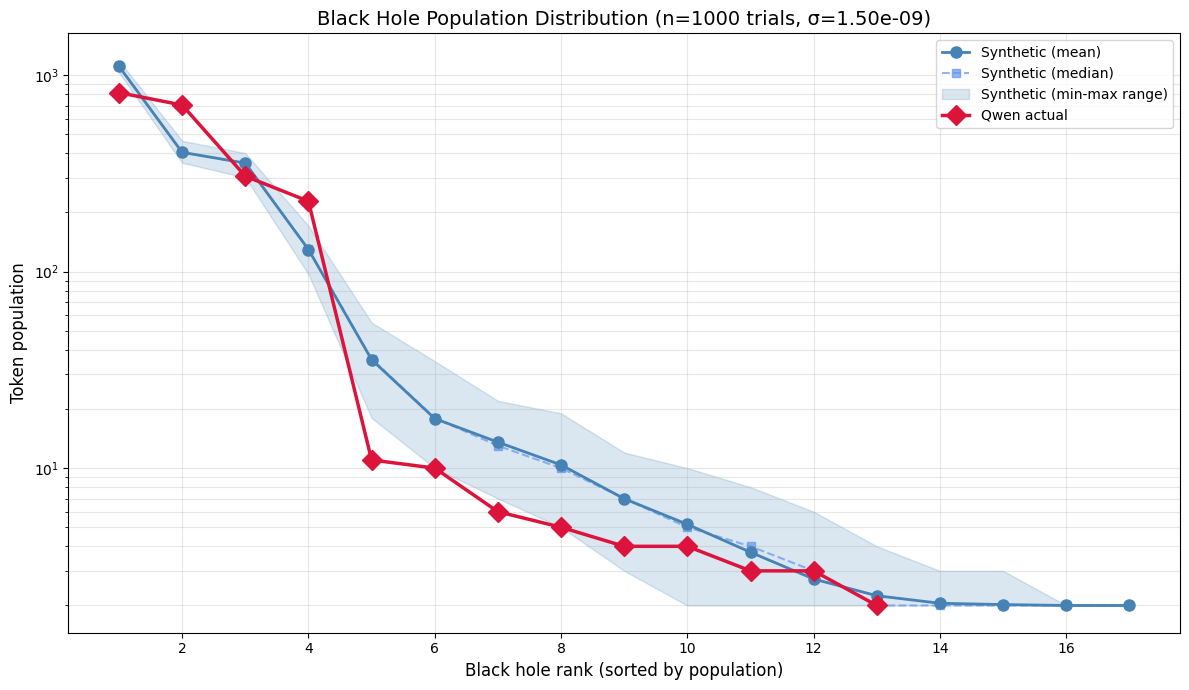

In [6]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

ranks = [s['rank'] for s in rank_stats]
means = [s['mean'] for s in rank_stats]
mins = [s['min'] for s in rank_stats]
maxs = [s['max'] for s in rank_stats]
medians = [s['median'] for s in rank_stats]

# Plot synthetic statistics
ax.plot(ranks, means, 'o-', color='steelblue', linewidth=2, markersize=8, label='Synthetic (mean)', zorder=3)
ax.plot(ranks, medians, 's--', color='cornflowerblue', linewidth=1.5, markersize=6, label='Synthetic (median)', alpha=0.7, zorder=2)
ax.fill_between(ranks, mins, maxs, color='steelblue', alpha=0.2, label='Synthetic (min-max range)', zorder=1)

# Overlay Qwen's actual distribution
qwen_ranks = list(range(1, len(QWEN_DISTRIBUTION) + 1))
ax.plot(qwen_ranks, QWEN_DISTRIBUTION, 'D-', color='crimson', linewidth=2.5, markersize=10, 
        label='Qwen actual', zorder=4)

ax.set_xlabel('Black hole rank (sorted by population)', fontsize=12)
ax.set_ylabel('Token population', fontsize=12)
ax.set_title(f'Black Hole Population Distribution (n={len(population_distributions)} trials, σ={SIGMA:.2e})', fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

## Concentration Analysis

In [7]:
print(f"\n{'='*60}")
print(f"CONCENTRATION ANALYSIS")
print(f"{'='*60}")

# Compute concentration metrics for each trial
top1_fractions = []
top2_fractions = []
top3_fractions = []

for dist in population_distributions:
    total = sum(dist)
    if total > 0:
        top1_fractions.append(dist[0] / total if len(dist) > 0 else 0)
        top2_fractions.append(sum(dist[:2]) / total if len(dist) > 1 else dist[0] / total if len(dist) > 0 else 0)
        top3_fractions.append(sum(dist[:3]) / total if len(dist) > 2 else sum(dist) / total)

# Qwen concentration
qwen_total = sum(QWEN_DISTRIBUTION)
qwen_top1 = QWEN_DISTRIBUTION[0] / qwen_total
qwen_top2 = sum(QWEN_DISTRIBUTION[:2]) / qwen_total
qwen_top3 = sum(QWEN_DISTRIBUTION[:3]) / qwen_total

print(f"\nPopulation concentration:")
print(f"\n{'Metric':<15} {'Synthetic Mean':<18} {'Qwen Actual':<15}")
print("-" * 50)
print(f"{'Top-1 BH':<15} {np.mean(top1_fractions)*100:>6.1f}% ± {np.std(top1_fractions)*100:>4.1f}%     {qwen_top1*100:>6.1f}%")
print(f"{'Top-2 BHs':<15} {np.mean(top2_fractions)*100:>6.1f}% ± {np.std(top2_fractions)*100:>4.1f}%     {qwen_top2*100:>6.1f}%")
print(f"{'Top-3 BHs':<15} {np.mean(top3_fractions)*100:>6.1f}% ± {np.std(top3_fractions)*100:>4.1f}%     {qwen_top3*100:>6.1f}%")

print(f"\n{'='*60}")


CONCENTRATION ANALYSIS

Population concentration:

Metric          Synthetic Mean     Qwen Actual    
--------------------------------------------------
Top-1 BH          52.9% ±  1.1%       38.8%
Top-2 BHs         72.2% ±  1.0%       72.3%
Top-3 BHs         89.2% ±  0.7%       86.9%



## Gini Coefficient (Inequality Measure)

In [8]:
def gini_coefficient(values):
    """
    Compute Gini coefficient (0 = perfect equality, 1 = perfect inequality).
    """
    sorted_values = np.sort(values)
    n = len(sorted_values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n

# Compute Gini for each trial
gini_coefficients = [gini_coefficient(dist) for dist in population_distributions]
qwen_gini = gini_coefficient(QWEN_DISTRIBUTION)

print(f"\n{'='*60}")
print(f"INEQUALITY ANALYSIS (Gini Coefficient)")
print(f"{'='*60}")
print(f"\nGini coefficient (0 = equal, 1 = concentrated):")
print(f"  Synthetic: {np.mean(gini_coefficients):.3f} ± {np.std(gini_coefficients):.3f}")
print(f"  Qwen:      {qwen_gini:.3f}")
print(f"\nInterpretation:")
if abs(np.mean(gini_coefficients) - qwen_gini) < 0.1:
    print(f"  ✓ Similar inequality levels")
elif np.mean(gini_coefficients) > qwen_gini:
    print(f"  ⚠ Synthetic distribution MORE concentrated than Qwen")
else:
    print(f"  ⚠ Synthetic distribution LESS concentrated than Qwen")
print(f"{'='*60}")


INEQUALITY ANALYSIS (Gini Coefficient)

Gini coefficient (0 = equal, 1 = concentrated):
  Synthetic: 0.763 ± 0.019
  Qwen:      0.753

Interpretation:
  ✓ Similar inequality levels


## Count vs. Largest-BH Correlation

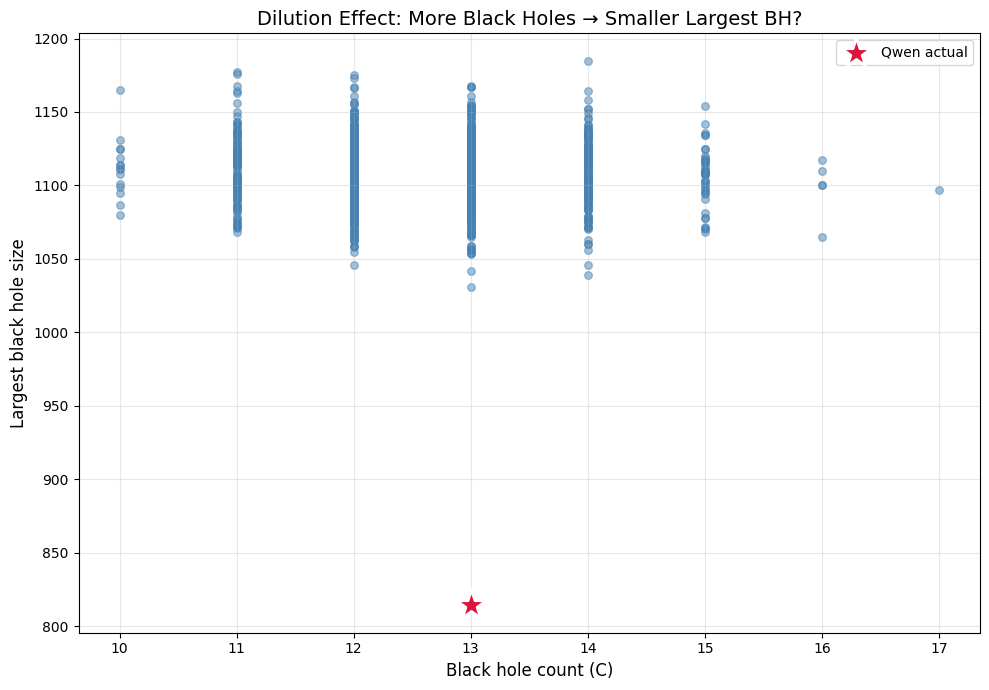


Correlation (C vs. largest BH): -0.043
  → Weak correlation


In [9]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

# Extract counts and largest BH sizes
counts = [len(dist) for dist in population_distributions]
largest_bhs = [dist[0] if dist else 0 for dist in population_distributions]

ax.scatter(counts, largest_bhs, alpha=0.5, s=30, color='steelblue')
ax.scatter([len(QWEN_DISTRIBUTION)], [QWEN_DISTRIBUTION[0]], 
           marker='*', s=500, color='crimson', edgecolor='white', linewidth=2,
           label='Qwen actual', zorder=10)

ax.set_xlabel('Black hole count (C)', fontsize=12)
ax.set_ylabel('Largest black hole size', fontsize=12)
ax.set_title('Dilution Effect: More Black Holes → Smaller Largest BH?', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Compute correlation
corr = np.corrcoef(counts, largest_bhs)[0, 1]
print(f"\nCorrelation (C vs. largest BH): {corr:.3f}")
if abs(corr) > 0.5:
    direction = "negative" if corr < 0 else "positive"
    print(f"  → Strong {direction} correlation")
else:
    print(f"  → Weak correlation")

## Concentration Histograms

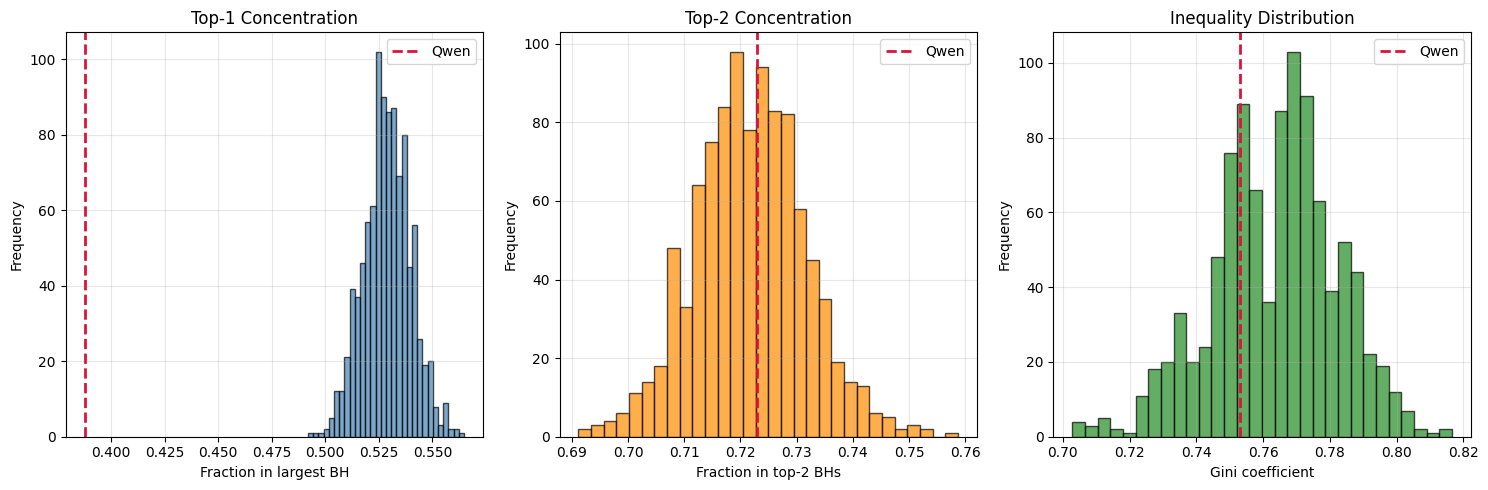

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

# Top-1 fraction
ax = axes[0]
ax.hist(top1_fractions, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(qwen_top1, color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Fraction in largest BH')
ax.set_ylabel('Frequency')
ax.set_title('Top-1 Concentration')
ax.legend()
ax.grid(True, alpha=0.3)

# Top-2 fraction
ax = axes[1]
ax.hist(top2_fractions, bins=30, color='darkorange', alpha=0.7, edgecolor='black')
ax.axvline(qwen_top2, color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Fraction in top-2 BHs')
ax.set_ylabel('Frequency')
ax.set_title('Top-2 Concentration')
ax.legend()
ax.grid(True, alpha=0.3)

# Gini coefficient
ax = axes[2]
ax.hist(gini_coefficients, bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
ax.axvline(qwen_gini, color='crimson', linestyle='--', linewidth=2, label='Qwen')
ax.set_xlabel('Gini coefficient')
ax.set_ylabel('Frequency')
ax.set_title('Inequality Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [11]:
print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Trials analyzed: {len(population_distributions):,}")
print(f"σ = {SIGMA:.2e}")
print(f"\nBlack hole structure:")
print(f"  Count (C): {df['n_black_holes'].mean():.1f} ± {df['n_black_holes'].std():.1f} (Qwen: {len(QWEN_DISTRIBUTION)})")
print(f"  Population (P): {df['black_hole_population'].mean():.0f} ± {df['black_hole_population'].std():.1f} (Qwen: {sum(QWEN_DISTRIBUTION)})")
print(f"\nDistribution comparison:")
print(f"  Largest BH: {means[0]:.0f} ± {np.std(rank_stats[0]['values']):.0f} (Qwen: {QWEN_DISTRIBUTION[0]})")
print(f"  2nd largest: {means[1]:.0f} ± {np.std(rank_stats[1]['values']):.0f} (Qwen: {QWEN_DISTRIBUTION[1]})")
print(f"  Top-1 concentration: {np.mean(top1_fractions)*100:.1f}% (Qwen: {qwen_top1*100:.1f}%)")
print(f"  Top-2 concentration: {np.mean(top2_fractions)*100:.1f}% (Qwen: {qwen_top2*100:.1f}%)")
print(f"  Gini coefficient: {np.mean(gini_coefficients):.3f} (Qwen: {qwen_gini:.3f})")

print(f"\nMatch quality:")
count_match = abs(df['n_black_holes'].mean() - len(QWEN_DISTRIBUTION)) < 1
pop_match = abs(df['black_hole_population'].mean() - sum(QWEN_DISTRIBUTION)) < 10
dist_match = abs(np.mean(gini_coefficients) - qwen_gini) < 0.1

if count_match and pop_match and dist_match:
    print(f"  ✓ EXCELLENT: Count, population, AND distribution match Qwen")
elif count_match and pop_match:
    print(f"  ✓ GOOD: Count and population match, distribution differs")
else:
    print(f"  ⚠ PARTIAL: Some metrics match, others differ")

print(f"{'='*60}")


SUMMARY
Trials analyzed: 1,000
σ = 1.50e-09

Black hole structure:
  Count (C): 12.8 ± 1.1 (Qwen: 13)
  Population (P): 2097 ± 1.6 (Qwen: 2100)

Distribution comparison:
  Largest BH: 1109 ± 23 (Qwen: 814)
  2nd largest: 404 ± 17 (Qwen: 704)
  Top-1 concentration: 52.9% (Qwen: 38.8%)
  Top-2 concentration: 72.2% (Qwen: 72.3%)
  Gini coefficient: 0.763 (Qwen: 0.753)

Match quality:
  ✓ EXCELLENT: Count, population, AND distribution match Qwen
